In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy import interpolate
%matplotlib inline

<div class="alert alert-block alert-info">
<h3 class="alert-heading">Random image generation</h3>
</div>

In [2]:
scaling_factor = 0.1
rescaled_imgsize = 64
big_imgsize = rescaled_imgsize / scaling_factor

def CreateImage(rescaled_imgsize, scaling_factor):
    #Create background
    big_imgsize = int(rescaled_imgsize / scaling_factor)
    full_imgsize = big_imgsize
    img = np.full((full_imgsize, full_imgsize),
                  np.random.randint(230,255),dtype = np.uint8)

    nb_speckles = np.random.randint(1e3,2e3)

    i=0
    while(i<nb_speckles):
        #random ellipse parameters
        center_val = (np.random.randint(0,full_imgsize),np.random.randint(0,full_imgsize))
        axis_len = (np.random.randint(8,18),np.random.randint(8,18))
        color_val = np.random.randint(0,90)
    
        #draw the ellipse
        cv2.ellipse(img,center_val,axis_len,0,0,360,color_val,-1)
        i += 1

    #resize image
    img = cv2.resize(img,(0,0),fx=scaling_factor, fy=scaling_factor,interpolation = 3)
    
    return img

<div class="alert alert-block alert-info">
<h3 class="alert-heading">Shape function definition</h3>
</div>

4---------3

1---------2

In [3]:
# The shape function is loosly defined and is only valid for reactangular 4-nodes quad elements.
# It can be transfered to generic 4-nodes quad by revising the calculation of eps and nu.
def FourNodeQuad(posnodes, dispnodes, X, Y):
    width = posnodes[1][0] - posnodes[0][0]
    height = width = posnodes[3][1] - posnodes[0][1]
    mult = 0.25

    eps = X/(width/2) - (posnodes[0][0] + 1)
    nu = Y/(height/2) - (posnodes[0][1] + 1)
    #definition of each node shape function value
    shp_f1 = mult * (1-eps) * (1-nu)
    shp_f2 = mult * (1+eps) * (1-nu)
    shp_f3 = mult * (1+eps) * (1+nu)
    shp_f4 = mult * (1-eps) * (1+nu)
    # computation of displacement at target point
    res_disp = [np.sum([shp_f1*dispnodes[0][0], shp_f2*dispnodes[1][0], shp_f3*dispnodes[2][0], shp_f4*dispnodes[3][0]],
                      axis=0),
                np.sum([shp_f1*dispnodes[0][1], shp_f2*dispnodes[1][1], shp_f3*dispnodes[2][1], shp_f4*dispnodes[3][1]],
                      axis=0)]
    return res_disp

#posnodes = [[2,2], [4,2], [4,4], [2,4]]
#dispnodes = [[0,0], [0.5,0], [0.5,0], [0,0]]
#X = np.array([2.5,3])
#Y = np.array([3,3])
#FourNodeQuad(posnodes, dispnodes, X, Y)

<div class="alert alert-block alert-info">
<h3 class="alert-heading">Displacement field & Deformed image calculation</h3>
</div>

In [4]:
def DistortImage(img, method='rand_disp', met_interp='linear', disps=None):   
    #assume initial node positions from image dims
    img_dims = np.array(img.shape)
    posnodes = [[0,0], [img_dims[0],0], [img_dims[0],img_dims[1]], [0,img_dims[1]]]
    
    if(method=="rand_disp"):
        #draw displacement values in pixels
        disps = np.round(np.random.randn(4,2)*5,1)

    #compute displacement of each pixel of the image
    x = np.arange(0, img_dims[0], 1)
    y = np.arange(0, img_dims[1], 1)
    xv, yv = np.meshgrid(x, y)
    mat_fullfield = FourNodeQuad(posnodes, disps, xv, yv)

    #compute new pixels positions
    xv_new = xv + mat_fullfield[0]
    yv_new = yv + mat_fullfield[1]
    
    #interpolate new image
    img_def = interpolate.griddata(points=np.array([xv_new.flatten(), yv_new.flatten()]).transpose(), 
                                   values=img.flatten(), 
                                   xi=np.array([xv.flatten(), yv.flatten()]).transpose(),
                                   method=met_interp,
                                   fill_value=0)
    img_orig_cropped = img[t_borders:img_dims[0] - t_borders, t_borders:img_dims[1] - t_borders]
    print("img_orig_cropped.shape: {}".format(img_orig_cropped.shape))
    img_orig_scaled = img_orig_cropped.reshape(rescaled_imgsize, rescaled_imgsize).astype('uint8')
    print("img_def.shape: {}".format(img_def.shape))
    img_def = img_def.reshape(rescaled_imgsize + 2*t_borders, rescaled_imgsize + 2*t_borders).astype('uint8')
    img_def = img_def[borders:img_def.shape[0]-borders, borders:img_def.shape[1]-borders]
    mat_fullfield = mat_fullfield.reshape((big_imgsize, big_imgsize))
    disp = mat_fullfield[borders:mat_fullfield.shape[0]-borders, borders:mat_fullfield.shape[1]-borders]
    img_def = img_def.reshape(rescaled_imgsize,rescaled_imgsize).astype('uint8')
    
    return {'image':img_def, 'disp':mat_fullfield}

<div class="alert alert-block alert-info">
<h3 class="alert-heading">Example image generation</h3>
</div>

In [13]:
from scipy import ndimage

a = np.arange(12.).reshape((4, 3))
x_mat = np.repeat(1.0, 4 * 3).reshape((4, 3))
y_mat = 1.0 * (np.repeat(1.0, 4 * 3).reshape((4, 3)))

def shift_func(output_coords):
    return (output_coords[0] - x_mat[output_coords], output_coords[1] - y_mat[output_coords])

ndimage.geometric_transform(a, shift_func)

    

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.32667268e-16,  1.00000000e+00],
       [ 0.00000000e+00,  3.00000000e+00,  4.00000000e+00],
       [ 0.00000000e+00,  6.00000000e+00,  7.00000000e+00]])

In [48]:
import scipy.ndimage
def deform_matrix(seed, shape, sigmas, smoothing_sigmas):
    x_location = np.random.randint(shape[0])
    y_location = np.random.randint(shape[1])
    x_displacement = np.random.normal(0.0, sigmas[0])
    y_displacement = np.random.normal(0.0, sigmas[1])
    dummy_xs = np.zeros(shape)
    dummy_ys = np.zeros(shape)
    dummy_xs[x_location, y_location] = x_displacement
    dummy_ys[x_location, y_location] = y_displacement
    smooth_xs = scipy.ndimage.gaussian_filter(dummy_xs, smoothing_sigmas[0])
    smooth_ys = scipy.ndimage.gaussian_filter(dummy_ys, smoothing_sigmas[1])
    return (smooth_xs, smooth_ys)

In [49]:
xd, yd = deform_matrix(13, (100, 200), (0.2, 2.0), (100.0, 2.1))

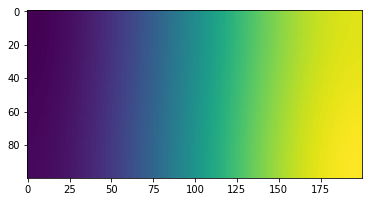

In [50]:
plt.imshow(xd);

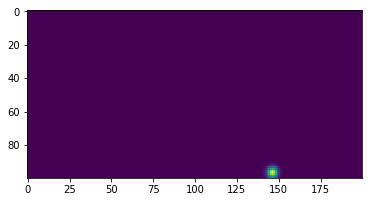

In [51]:
plt.imshow(yd)

In [52]:
from scipy import ndimage

def shift_elements(original, deformations):
    x_def, y_def = deformations
    def shift_func(image):
        return (image[0] - x_def[image], image[1] - y_def[image])
    return ndimage.geometric_transform(original, shift_func)

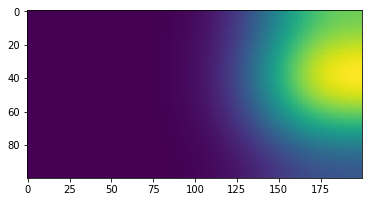

In [53]:
a = deform_matrix(13, (100, 200), (20, 10), (30., 50.))[0]
plt.imshow(a)

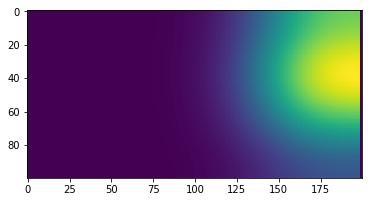

In [54]:
ad = deform_matrix(6345616, a.shape, (200.0, 110.0), (10.0, 50.0))
shifted = shift_elements(a, ad)
plt.imshow(shifted)

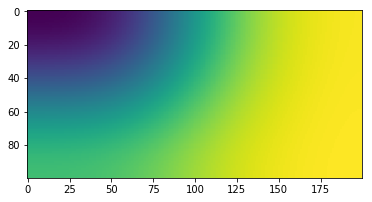

In [55]:
plt.imshow(ad[1])

In [56]:
((a - shifted)/(shifted + 0.1)).max()

0.012118840908140216

In [57]:
im = CreateImage(64, 0.1)

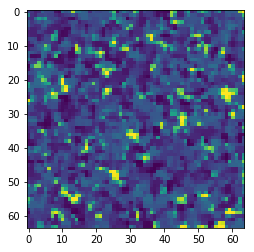

In [58]:
plt.imshow(im)

In [59]:
ims = shift_elements(im, deform_matrix(None, im.shape, (10, 10), (5, 5)))

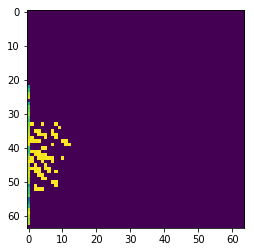

In [60]:
plt.imshow(ims - im)

In [215]:
def generate_pair(seed, displacement_sigmas, smoothing_sigmas, imsize=64, scaling_factor=0.1):
    orig = CreateImage(imsize, scaling_factor)
    deformations = deform_matrix(seed, orig.shape, displacement_sigmas, smoothing_sigmas)
    shifted = shift_elements(orig, deformations)
    return ((orig, shifted), deformations)

def generate_stacked(seed, displacement_sigmas, smoothing_sigmas, imsize=64, scaling_factor=0.1):
    ors, deform = generate_pair(seed, displacement_sigmas, smoothing_sigmas, imsize=imsize, scaling_factor=scaling_factor)
    o, rs = ors
    dx, dy = deform
    return (np.stack([o, rs], axis=-1), np.stack([dx, dy], axis=-1))


In [216]:
from keras.utils import Sequence

class ImageSequence(Sequence):

    def __init__(self, batch_size,
                 displacement_sigmas, smoothing_sigmas,
                 imsize=64, scaling_factor=0.1,
                 maxlen = 10000):
        self.batch_size = batch_size
        self.maxlen = maxlen
        self.displacement_sigmas = displacement_sigmas
        self.smoothing_sigmas = smoothing_sigmas
        self.imsize = imsize
        self.scaling_factor = scaling_factor

    def __len__(self):
        return self.maxlen

    def __getitem__(self, idx):
        inputs = []
        outputs = []
        for i in range(self.batch_size):
            inp, outp = generate_stacked(np.random.randint(1000),
                                         self.displacement_sigmas,
                                         self.smoothing_sigmas,
                                         self.imsize,
                                         self.scaling_factor)
            inputs.append(inp)
            outputs.append(outp)
        
        return (np.array(inputs), np.array(outputs))

In [217]:
ims = ImageSequence(8, (10, 10), (5, 5))

In [218]:
batch = ims.__getitem__(10)

In [219]:
batch[0].shape

(8, 64, 64, 2)

In [294]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Reshape, LeakyReLU

class DeepModel2(Sequential):

    def __init__(self, imsize, batch_size):
        inp = Input(shape=(imsize, imsize, 2), dtype='float32')
        conv = Conv2D(64, 7, strides=(1, 1), padding='valid', activation='relu')(BatchNormalization(axis=3)(inp))
        conv = Conv2D(128, 5, strides=(1, 1), padding='valid', activation='relu')(BatchNormalization(axis=3)(conv))
        conv = Conv2D(256, 5, strides=(1, 1), padding='valid', activation='relu')(BatchNormalization(axis=3)(conv))
        conv = Conv2DTranspose(256, 5, strides=(1, 1), padding='valid', activation='relu')(BatchNormalization(axis=3)(conv))
        conv = Conv2DTranspose(128, 5, strides=(1, 1), padding='valid', activation='relu')(BatchNormalization(axis=3)(conv))
        conv = Conv2DTranspose(2, 7, strides=(1, 1), padding='valid')(BatchNormalization(axis=3)(conv))
        final = conv
        self.model = Model(inputs=inp, outputs=final)

    def rate(self, batch):
        
        return self.model.predict(batch)[0][0]

In [295]:
deepModel = DeepModel2(64, 8).model

In [296]:
from keras import optimizers
from keras import metrics

sgd = optimizers.SGD(lr=0.007, decay=0.0, momentum=0.05, nesterov=True, clipnorm=1.0)
deepModel.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mean_squared_error'])

In [297]:
deepModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 64, 64, 2)         0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 64, 64, 2)         8         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 58, 58, 64)        6336      
_________________________________________________________________
batch_normalization_70 (Batc (None, 58, 58, 64)        256       
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 54, 54, 128)       204928    
_________________________________________________________________
batch_normalization_71 (Batc (None, 54, 54, 128)       512       
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 50, 50, 256)       819456    
__________

In [313]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler

MODEL_WEIGHTS_FILE = 'flow_simple_tunnel.h5'

def schedule(epoch, lr=0.01):
    lr_max = 0.01
    lr_min = 0.00001
    return lr_min + (0.6 ** (epoch % 10)) * lr_max

callbacks = [EarlyStopping('val_loss', patience=5),
             LearningRateScheduler(schedule, verbose=1),
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]

gen = ImageSequence(8, (20, 20), (5, 5), maxlen=64)
test_gen = ImageSequence(8, (20, 20), (5, 5), maxlen=16)
history = deepModel.fit_generator(generator=gen,
                                  validation_data=test_gen,
                                  callbacks=callbacks,
                                  use_multiprocessing=True,
                                  workers=4,
                                  epochs=35)


Epoch 1/35

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01001.
63/64 [============================>.] - ETA: 4s - loss: 0.1266 - mean_squared_error: 0.0421
Epoch 00001: LearningRateScheduler reducing learning rate to 0.01001.
64/64 [==============================] - 329s 5s/step - loss: 0.1270 - mean_squared_error: 0.0424 - val_loss: 0.1191 - val_mean_squared_error: 0.0386
Epoch 2/35

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00601.
64/64 [==============================] - 322s 5s/step - loss: 0.1013 - mean_squared_error: 0.0258 - val_loss: 0.1167 - val_mean_squared_error: 0.0371
Epoch 3/35

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00361.
64/64 [==============================] - 321s 5s/step - loss: 0.0910 - mean_squared_error: 0.0210 - val_loss: 0.1059 - val_mean_squared_error: 0.0300
Epoch 4/35

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0021699999999999996.
64/64 [==============================] - 325s

64/64 [==============================] - 330s 5s/step - loss: 0.0633 - mean_squared_error: 0.0109 - val_loss: 0.0736 - val_mean_squared_error: 0.0154
Epoch 35/35

Epoch 00035: LearningRateScheduler reducing learning rate to 0.001306.
64/64 [==============================] - 345s 5s/step - loss: 0.0600 - mean_squared_error: 0.0099 - val_loss: 0.0675 - val_mean_squared_error: 0.0129


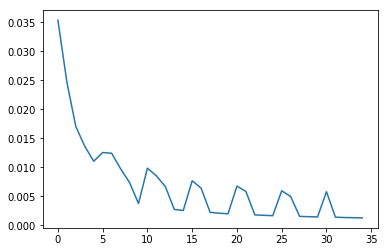

In [119]:
plt.plot(history.history['val_loss'])

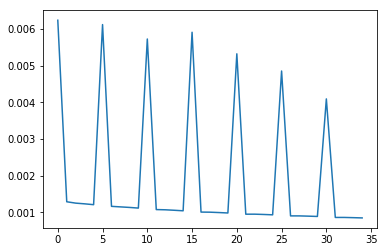

In [137]:
plt.plot(history.history['val_loss'])

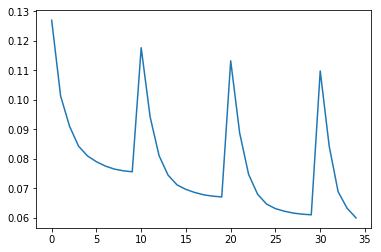

In [314]:
plt.plot(history.history['loss'])

In [315]:
item0, answer0 = gen.__getitem__(3)
pred = deepModel.predict(item0)

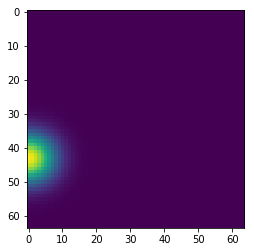

In [170]:
plt.imshow(answer0[0][0])

In [303]:
def to_polar(init_flow):
    flow = init_flow
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3))
    #hsv[:,:,1] = cv2.cvtColor(init_flow[1], cv2.COLOR_RGB2HSV)[:,:,1]
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    # convert HSV to int32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb_flow 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


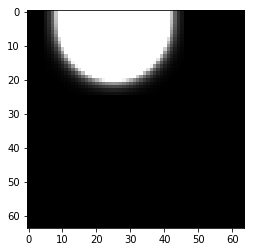

In [316]:
plt.imshow(to_polar(answer0[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


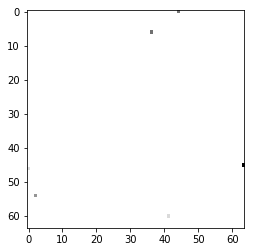

In [317]:
plt.imshow(to_polar(pred[1]))

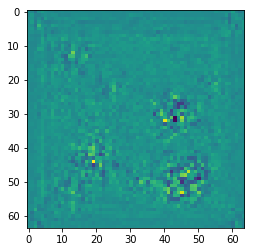

In [318]:
plt.imshow(pred[1][:, :, 1])

In [311]:
pred[1][:, :, 1].min()

-1.320548

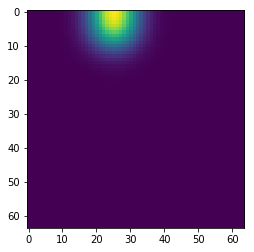

In [319]:
plt.imshow(answer0[1][:, :, 1])